# exp3 多类别逻辑回归、神经网络
本项目包含吴恩达机器学习ex3的python实现，主要知识点为 多类别逻辑回归、神经网络。 
参考： https://www.heywhale.com/mw/project/5da56d46c83fb4004202c42b

确实 matrix和 array的乘法是真的很离谱

# 1 多分类
这个部分需要你实现手写数字（0-9）的是被，需要扩赞之前的逻辑回归，并将其应用于one versu more的分类。

## 1.1 数据集
这个数据集是一个matlab格式的.m文件，其中包含5000个20*20像素的手写字体图像，以及他对应的数字。另外，数字0的y值对应的是10。
用python读取我们需要使用SciPy.

In [243]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from scipy.io import loadmat
from sklearn.metrics import classification_report#这个包是评价报告

In [244]:
path = './Andrew-NG-Meachine-Learning/machine-learning-ex3/ex3/ex3data1.mat'
data = loadmat(path)
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct 16 13:09:09 2011',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'y': array([[10],
        [10],
        [10],
        ...,
        [ 9],
        [ 9],
        [ 9]], dtype=uint8)}

In [245]:
data['X'].shape, data['y'].shape

((5000, 400), (5000, 1))

## 1.2 数据可视化
随机展示100个数据

In [246]:
count = data['X'].shape[0]
sample_idx = np.random.choice(np.arange(count), 100)
sample_images = data['X'][sample_idx, :]
sample_images.shape

(100, 400)

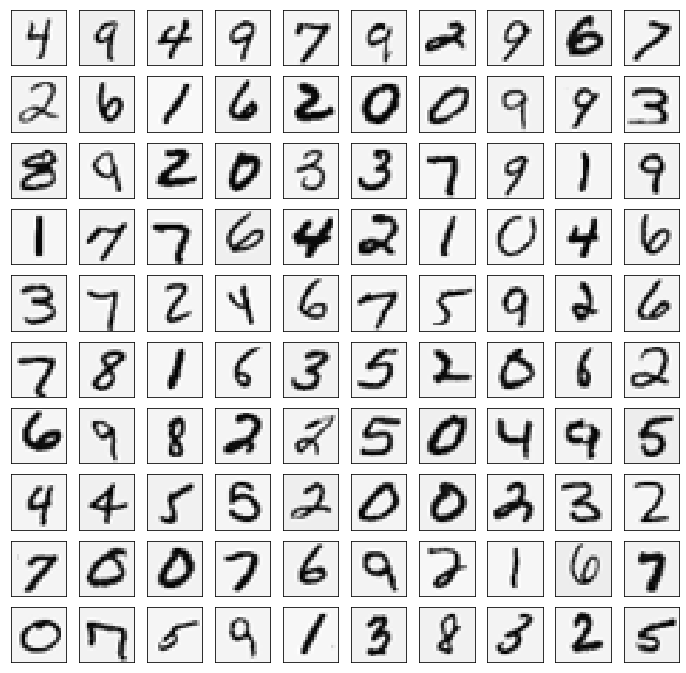

In [247]:
# 画图
fig, ax_array = plt.subplots(nrows=10, ncols=10, sharey=True, sharex=True, figsize=(12, 12))
for r in range(10):
    for c in range(10):
        ax_array[r, c].matshow(np.array(sample_images[10 * r + c].reshape((20, 20))).T, cmap=matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([])) 

## 1.3 将逻辑回归向量化
你将用多分类逻辑回归做一个分类器。因为现在有10个数字类别，所以你需要训练10个不同的逻辑回归分类器。为了让训练效率更高，将逻辑回归向量化是非常重要的，不要用循环。

### 1.3.1 向量化函数

$$
    h_\theta(x) = \frac{1}{1 + e^{-\theta^Tx}}
$$

In [248]:
# sigmoid 
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

$$
        J(\theta) = \frac{1}{m} \sum_{i = 1}^{m} \left[-y^{(i)}log\left(h_\theta(x^{(i)})\right) - 
        \left(1 - y^{(i)}\right)log\left(1 - h_\theta(x^{(i)}\right)  \right] + 
        \frac{\lambda}{2m}\sum_{j=1}^{n}\theta_j^2
$$

In [249]:
a = np.arange(4)
a = a.reshape(-1, 1)
a.T.dot(a)

array([[14]])

In [250]:
# cost
def cost(theta, X, y, lambd):
    """
    X: array (m, n) 
    y: array (m, 1)
    theta: (n,)
    lambd: float
    """
    theta = theta.reshape(-1, 1)
    h = sigmoid(X.dot(theta))
    error = np.sum(-y*(np.log(h)) - (1-y)*(np.log(1 - h)) ) / len(X)
    reg = theta.T.dot(theta) * lambd / (2 * len(X))
    return error + reg

$$
        \frac{\partial J(\theta)}{ \partial \theta_j} = \frac{1}{m} \sum_{i=1}^{m} \left(  
                (h_\theta(x^{(i)}) - y^{(i)})x_j^{(i)}
        \right) + \frac{\lambda}{m}\theta_j , j \ge 1
$$

In [251]:
# gradient
def gradient(theta, X, y, lambd):
    """
    X: array (m, n) 
    y: array (m, 1)
    theta: (n,)
    lambd: float
    """
    _theta = theta.reshape(-1, 1)
    left = X.T.dot(sigmoid(X.dot(_theta)) - y) / len(X)
    left = left.T[0]
    right0 = np.array([0])
    right1 = lambd * theta[1:] / len(X)
    right = np.append(right0, right1)
    assert(left.shape == right.shape)
    return left + right

## 1.4 one versus all
现在我们已经定义了代价函数和梯度函数，现在是构建分类器的时候了。

对于这个任务，我们有10个可能的类，并且由于逻辑回归只能一次在2个类之间进行分类，我们需要多类分类的策略。

在本练习中，我们的任务是实现一对一全分类方法，其中具有k个不同类的标签就有k个分类器，每个分类器在“类别 i”和“不是 i”之间决定。

我们将把分类器训练包含在一个函数中，该函数计算10个分类器中的每个分类器的最终权重，并将权重返回为k*(n + 1)数组，其中n是参数数量。

In [252]:
a = np.diag(np.arange(3))
np.insert(a, 3, np.diag(np.arange(3)), axis = 0)

array([[0, 0, 0],
       [0, 1, 0],
       [0, 0, 2],
       [0, 0, 0],
       [0, 1, 0],
       [0, 0, 2]])

In [253]:
from scipy.optimize import minimize

def one_vs_all(X, y, num_labels, lambd): 
    """
    X: array (m, n) 
    y: array (m, 1)
    num_labels: category
    lambd: float
    """
    m = X.shape[0]
    n = X.shape[1]
    # 初始化theta为 (m, n + 1)， 因为多了一列 theta_0 
    all_theta = np.zeros((num_labels, n + 1))
    ## 添加 theta_0 对应的 x 为1
    X = np.insert(X, 0, values = np.ones(m), axis = 1)

    ## 循环计算最后的结果labels 1 - 10的分类结果
    for i in range(1, num_labels + 1): 
        ## 初始化(n+1,)
        theta = np.zeros(n + 1)
        ## 对y进行处理, 分类器在类别i 和不是i进行分类, 并且处理为(m,1)
        y_i = np.array([1 if i == label else 0 for label in y]).reshape(-1, 1)

        fmin = minimize(fun=cost, x0=theta, args=(X, y_i, lambd), method='TNC', jac=gradient)
        all_theta[i-1,:] = fmin.x
    return all_theta

In [254]:
np.unique(data['y'])#看下有几类标签

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8)

In [255]:
all_theta = one_vs_all(data['X'], data['y'], 10, 1)
all_theta

array([[-2.28167351e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.21211939e-03,  2.03039327e-08,  0.00000000e+00],
       [-3.17934722e+00,  0.00000000e+00,  0.00000000e+00, ...,
         4.45122127e-03, -5.07402406e-04,  0.00000000e+00],
       [-4.78530862e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -2.86844769e-05, -2.48077846e-07,  0.00000000e+00],
       ...,
       [-7.92522629e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -9.71532531e-05,  7.45095407e-06,  0.00000000e+00],
       [-4.57449712e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.28287571e-03,  9.49563814e-05,  0.00000000e+00],
       [-5.02872815e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -9.55233709e-05,  1.12916827e-05,  0.00000000e+00]])

In [256]:
a = np.arange(9).reshape(3,3)
b = np.sum(a, 0)
a, b

(array([[0, 1, 2],
        [3, 4, 5],
        [6, 7, 8]]),
 array([ 9, 12, 15]))

In [257]:
def predict_all(X, all_theta):
    rows = X.shape[0]
    params = X.shape[1]
    num_labels = all_theta.shape[0]
    
    # same as before, insert ones to match the shape
    X = np.insert(X, 0, values=np.ones(rows), axis=1)
    
    # convert to matrices
    X = np.matrix(X)
    all_theta = np.matrix(all_theta)
    
    # compute the class probability for each class on each training instance
    h = sigmoid(X * all_theta.T)
    
    # create array of the index with the maximum probability
    h_argmax = np.argmax(h, axis=1)
    
    # because our array was zero-indexed we need to add one for the true label prediction
    h_argmax = h_argmax + 1
    
    return h_argmax

使用predict_all为每个实例生成预测，然后求precision,recall,f1-score，这里使用classification_report函数直接进行求解。

In [258]:
y_pred = predict_all(data['X'], all_theta)
print(classification_report(data['y'], y_pred))

              precision    recall  f1-score   support

           1       0.95      0.99      0.97       500
           2       0.95      0.92      0.93       500
           3       0.95      0.91      0.93       500
           4       0.95      0.95      0.95       500
           5       0.92      0.92      0.92       500
           6       0.97      0.98      0.97       500
           7       0.95      0.95      0.95       500
           8       0.93      0.92      0.92       500
           9       0.92      0.92      0.92       500
          10       0.97      0.99      0.98       500

    accuracy                           0.94      5000
   macro avg       0.94      0.94      0.94      5000
weighted avg       0.94      0.94      0.94      5000



# 2. 神经网络
在前面一个部分，我们已经实现了多酚类逻辑回归来识别手写数字。

但是，逻辑回归并不能承载更复杂的假设，因为它是一个线性分类器。

这一部分，我们来实现一个可以识别手写数字的神经网络。神经网络可以表示一些非线形复杂的模型。

这里的 **权重**已经预先训练好，目标是在现有的权重基础上，来实现前馈神经网络。


## 2.1 模型表达
现有的模型如下： 这里就不插入图片了。

中间有1个隐藏层。

输入的是图片的像素值，20*20的图片有400个输入层单元，不包括额外添加的常数项。

材料提供了训练好的神经网络参数 $\theta^{(0)}$ 、 $\theta^{(1)}$。 其中隐藏单元个数是25个，输出单元个数是10个。

In [259]:
# 不读入文件，其实就可以知道， weight1的权重为 (25, 401), weight2的权重为 (10, 26)，后面打印其实也是这个数值
weight = loadmat("./Andrew-NG-Meachine-Learning/machine-learning-ex3/ex3/ex3weights.mat")
theta1, theta2 = weight['Theta1'], weight['Theta2']
theta1.shape, theta2.shape

((25, 401), (10, 26))

计算 $a^{(1)}$

In [268]:
# 插入常数项
X2 = np.insert(data['X'], 0, values = np.ones(data['X'].shape[0]), axis = 1)
y2 = data['y']
# 这里就不按照机器学习的(m, n)来表示X了， 按照X(n, m) 来表示
X2.T.shape, theta1.shape, theta2.shape, y2.shape

((401, 5000), (25, 401), (10, 26), (5000, 1))

In [286]:
# 计算a1
a0 = X2.T
z1 = np.dot(theta1, a0)
a1 = sigmoid(z1)
# 并且插入常数项
a1 = np.insert(a1, 0, values = np.ones(a1.shape[1]), axis = 0)
a1.shape

(26, 5000)

In [310]:
# 计算a2 
z2 = np.dot(theta2, a1)
a2 = sigmoid(z2)
a2.T

array([[1.12661530e-04, 1.74127856e-03, 2.52696959e-03, ...,
        4.01468105e-04, 6.48072305e-03, 9.95734012e-01],
       [4.79026796e-04, 2.41495958e-03, 3.44755685e-03, ...,
        2.39107046e-03, 1.97025086e-03, 9.95696931e-01],
       [8.85702310e-05, 3.24266731e-03, 2.55419797e-02, ...,
        6.22892325e-02, 5.49803551e-03, 9.28008397e-01],
       ...,
       [5.17641791e-02, 3.81715020e-03, 2.96297510e-02, ...,
        2.15667361e-03, 6.49826950e-01, 2.42384687e-05],
       [8.30631310e-04, 6.22003774e-04, 3.14518512e-04, ...,
        1.19366192e-02, 9.71410499e-01, 2.06173648e-04],
       [4.81465717e-05, 4.58821829e-04, 2.15146201e-05, ...,
        5.73434571e-03, 6.96288990e-01, 8.18576980e-02]])

In [311]:
## 计算每一个当中的最大值 argmax: arguments of the maxima 
y_pred2 = np.argmax(a2, axis=0) + 1
y_pred2 = y_pred2.reshape(-1, 1)
y_pred2.shape

(5000, 1)

In [312]:
print(classification_report(y2, y_pred2))

              precision    recall  f1-score   support

           1       0.97      0.98      0.98       500
           2       0.98      0.97      0.98       500
           3       0.98      0.96      0.97       500
           4       0.97      0.97      0.97       500
           5       0.97      0.98      0.98       500
           6       0.98      0.99      0.98       500
           7       0.98      0.97      0.97       500
           8       0.98      0.98      0.98       500
           9       0.97      0.96      0.96       500
          10       0.98      0.99      0.99       500

    accuracy                           0.98      5000
   macro avg       0.98      0.98      0.98      5000
weighted avg       0.98      0.98      0.98      5000

